# Differential Privacy for  Iot_intrusion Dataset
*Project Background:* <br>
We, as a student, has a labeled private dataset and an unlabeled public dataset. We would like to collaberate with certain number of teachers to label our public dataset by training their similar datasets. In order to protect the data privacy of the teachers, we agree to add global noise to the labels they return for the public dataset. Then we label our public dataset based on the labels that most teachers agree. We combine the new labels with the public dataset and train with our private dataset. <br>

*PATE analysis* is performed on teachers' predictions and the new labels with certain level of epsilon indicating how much information leakage is allowed.

In [1]:
# # install syft package to use Private Aggregation of Teacher Ensembles (PATE)
# %%capture
# !pip install --upgrade syft==0.2.9

In [2]:
# %%capture
# !pip install syft

In [3]:
# import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset, TensorDataset
from torch.utils.data.dataset import random_split
from torch import nn, optim
import torch.nn.functional as F
# from syft.frameworks.torch.differential_privacy import pate
# import syft as sy
import matplotlib.pyplot as plt

import os
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
     auc,
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from imblearn.over_sampling import RandomOverSampler

#Filtering errors
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Section 1: Download and load Iot_intrusion dataset

*   **Trainset**: divide among teachers without overlapping
*   **Testset**: split into private(labeled) and public(unlabeled) datasets; use models trained by teachers to label public dataset and train with the private dataset



In [4]:
from google.colab import drive
drive.mount('/content/drive')

data  = pd.read_csv('/content/drive/MyDrive/IoT_Intrusion.csv')
target_column = 'label'
data = data[data[target_column].isin(['DDoS-ICMP_Flood','DDoS-UDP_Flood','DDoS-TCP_Flood'])]
num_classes = data[target_column].nunique()

# Add Upsampling
# Separate features and target
X = data.drop(columns=[target_column])
y = data[target_column]

# Perform upsampling (for synthetic minority over sampling() smote)
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)
# put it in one area rebuild dataset
data = pd.concat([X_resampled, y_resampled], axis=1)

# Label encode the target column(convert text to numbers)
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Encode the target column
data[target_column] = label_encoder.fit_transform(data[target_column])

# # Identify non-numeric columns (only two so dropping)
# print(data.select_dtypes(include='object').columns)

# data.drop(['proto', 'service'], axis=1, inplace=True)

Mounted at /content/drive


In [5]:
# Separate features and target
y = data[target_column].values
X = data.drop(columns=[target_column]).values  #

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Define a custom dataset
class TabularDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


# Create datasets
trainset = TabularDataset(X_train, y_train)
testset = TabularDataset(X_test, y_test)

# Data loaders
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

In [6]:
# training and test data info
print('num training data: {0}'.format(len(trainset)))
print('num test data: {0}'.format(len(testset)))

num training data: 411266
num test data: 72577


### Section 2: Functions


*   `teacher_data_allocator`: evenly allocate training dataset to the number of teachers as their private datasets
*   `private_public_allocator`: split test dataset as the student's private dataset and public dataset
*   `train`: model training with training and valid datasets
*   `get_label_testset`: get labels of the student's public dataset from all teachers
*   `add_global_noise`: add global noise to the labels that most teachers agree
*   `create_labeled_public_db`: extract images from the public dataset and combine these images with the new labels; create a new dataloader for this new dataset



In [7]:
# divide unique training datasets among teachers
# split each dataset into training and valid sets
def teacher_data_allocator(trainset, batch_size=64, num_teachers=10, valid_train_split=0.3):
  data_per_teacher = len(trainset) // num_teachers    # round to the nearest integer
  train_loaders = []
  valid_loaders = []
  for i in range(num_teachers):
    if i == num_teachers - 1:
      ind = list(range(i * data_per_teacher, len(trainset)))
    else:
      ind = list(range(i * data_per_teacher, (i + 1) * data_per_teacher))
    data = Subset(trainset, ind)
    split = int(valid_train_split * len(data))
    valid_data, train_data = random_split(data, [split, len(data) - split])
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)
    train_loaders.append(train_loader)
    valid_loaders.append(valid_loader)
  return train_loaders, valid_loaders

In [8]:
# divide testset into private and public
def private_public_allocator(dataset, batch_size=64, split=0.7):
  split_ind = int(len(dataset) * split)

  # validset and testset
  # validset is smaller because dataset of each teacher is small
  private_ind = list(range(0, split_ind))
  public_ind = list(range(split_ind, len(dataset)))
  private_set = Subset(dataset, private_ind)
  public_set = Subset(dataset, public_ind)

  # validloader and testloader
  private_loader = torch.utils.data.DataLoader(private_set, batch_size=batch_size, shuffle=True)
  public_loader = torch.utils.data.DataLoader(public_set, batch_size=batch_size, shuffle=False)
  return private_loader, public_loader

In [9]:
def train(model, criterion, optimizer, trainloader, validloader, epochs=30, patience=3, plot=False):
    model = model
    criterion = criterion
    optimizer = optimizer
    epochs = epochs

    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    # Early stopping variables
    best_valid_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    for e in range(epochs):
        if early_stop:
            print("Early stopping triggered")
            break

        running_loss = 0
        correct_train = 0
        total_train = 0

        # Training loop
        model.train()
        for inputs, labels in trainloader:
            optimizer.zero_grad()

            log_ps = model(inputs)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Track accuracy for training
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            correct_train += equals.sum().item()
            total_train += labels.size(0)

        # Validation loop
        valid_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            model.eval()
            for inputs, labels in validloader:
                log_ps = model(inputs)
                valid_loss += criterion(log_ps, labels).item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                correct_val += equals.sum().item()
                total_val += labels.size(0)

        # Calculate average losses and accuracies
        train_losses.append(running_loss / len(trainloader))
        valid_losses.append(valid_loss / len(validloader))
        train_accuracies.append(correct_train / total_train)
        valid_accuracies.append(correct_val / total_val)

        # Print progress
        print(f"Epoch: {e+1}/{epochs}.. "
              f"Training Loss: {running_loss / len(trainloader):.3f}.. "
              f"Validation Loss: {valid_loss / len(validloader):.3f}.. "
              f"Validation Accuracy: {correct_val / total_val:.3f}")

        # Early stopping check
        current_valid_loss = valid_loss / len(validloader)
        if current_valid_loss < best_valid_loss:
            best_valid_loss = current_valid_loss
            epochs_no_improve = 0  # Reset counter
            best_model_state = model.state_dict()  # Save best model
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Validation loss has not improved for {patience} epochs. Stopping early.")
            early_stop = True

    # Load the best model state before returning
    model.load_state_dict(best_model_state)

    if plot:
        return model, train_losses, valid_losses, train_accuracies, valid_accuracies
    else:
        return model


In [10]:
# label testset by models
def get_label_testset(models, testloader):
  test_labels = []
  for model in models:
    test_label = []
    for inputs, _ in testloader:
      with torch.no_grad():
        log_ps = model(inputs)
        ps = torch.exp(log_ps)
      top_p, top_class = ps.topk(1, dim=1)
      test_label.append(top_class.squeeze().tolist())
    test_label = sum(test_label, [])
    test_labels.append(test_label)
  return test_labels

In [11]:
# get predictions with global noise
def add_global_noise(preds, epsilon=0.1):
  labels_with_noise = []
  for pred in preds:    # go thru entries
    label_counts = np.bincount(pred, minlength=preds.shape[1])

    epsilon = epsilon
    beta = 1 / epsilon

    for i in range(len(label_counts)):
      label_counts[i] += np.random.laplace(0, beta, 1)

    new_label = np.argmax(label_counts) % num_classes
    labels_with_noise.append(new_label)
  return np.array(labels_with_noise)

In [12]:
# create a new dataloader for the public dataset
# using the new labels added global noise
def create_labeled_public_db(dataloader, labels, batch_size=64):
  image_list = []
  for image, _ in dataloader:
    image_list.append(image)
  data = np.vstack(image_list)
  new_dataloader = list(zip(data, labels))
  new_dataloader = torch.utils.data.DataLoader(new_dataloader, shuffle=False, batch_size=batch_size)
  return new_dataloader

### Section 3: Define neural network model structure

In [13]:
import torch.nn as nn
import torch.nn.functional as F

best_hp = {
'units_1': 128,
'dropout_1': 0.35,
'num_layers': 4,
'dropout_0': 0.3,
'learning_rate': 0.0001,
'optimizer': 'adam',
'dropout_2': 0.1,
'dropout_3': 0.25,
'dropout_4': 0.4,
}

input_size = X_train.shape[1]

# Classifier for tabular data
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        # Define layers with hyperparameters from best_hp
        self.fc1 = nn.Linear(input_size, best_hp['units_1'])
        self.fc2 = nn.Linear(best_hp['units_1'], 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)

        # Dropout layers with hyperparameters from best_hp
        self.dropout0 = nn.Dropout(p=best_hp['dropout_0'])
        self.dropout1 = nn.Dropout(p=best_hp['dropout_1'])
        self.dropout2 = nn.Dropout(p=best_hp['dropout_2'])
        self.dropout3 = nn.Dropout(p=best_hp['dropout_3'])
        self.dropout4 = nn.Dropout(p=best_hp['dropout_4'])

    def forward(self, x):
        # Applying forward pass with respective dropout layers
        x = self.dropout0(F.relu(self.fc1(x)))
        x = self.dropout1(F.relu(self.fc2(x)))
        x = self.dropout2(F.relu(self.fc3(x)))
        x = self.dropout3(self.fc4(x))
        x = F.log_softmax(self.dropout4(x), dim=1)

        return x


### Section 4: Model training and PATE analysis
We first ask the teachers to train their data and use these models to label the student's public data. After adding the global noise to create the new labels for the public dataset, the student then trains his/her private (training set) and public (valid set) data. PATE analysis returns independent and dependent epsilons show how much information has been leaked and how much teachers agree with each other.

In [14]:
# allocate training dataset to teachers
# split each of these datasets into training and valid datasets
teachers_train, teachers_valid = teacher_data_allocator(trainset)
print(len(teachers_train))
print(len(teachers_valid))

10
10


In [15]:
# allocate test dataset to the student
# split the dataset into private and public datasets
private_loader, public_loader = private_public_allocator(testset)
print(len(private_loader))
print(len(public_loader))

794
341


In [16]:
# get models trained by each teacher
teacher_models = []
for teacher_train, teacher_valid in zip(teachers_train, teachers_valid):
  model = Classifier()
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0001)
  teacher_model = train(model, criterion, optimizer, teacher_train, teacher_valid)
  teacher_models.append(teacher_model)

Epoch: 1/30.. Training Loss: 0.696.. Validation Loss: 0.082.. Validation Accuracy: 0.998
Epoch: 2/30.. Training Loss: 0.390.. Validation Loss: 0.036.. Validation Accuracy: 0.999
Epoch: 3/30.. Training Loss: 0.388.. Validation Loss: 0.032.. Validation Accuracy: 0.999
Epoch: 4/30.. Training Loss: 0.385.. Validation Loss: 0.031.. Validation Accuracy: 0.999
Epoch: 5/30.. Training Loss: 0.380.. Validation Loss: 0.030.. Validation Accuracy: 0.999
Epoch: 6/30.. Training Loss: 0.377.. Validation Loss: 0.028.. Validation Accuracy: 0.999
Epoch: 7/30.. Training Loss: 0.378.. Validation Loss: 0.028.. Validation Accuracy: 0.999
Epoch: 8/30.. Training Loss: 0.378.. Validation Loss: 0.020.. Validation Accuracy: 0.999
Epoch: 9/30.. Training Loss: 0.381.. Validation Loss: 0.024.. Validation Accuracy: 0.999
Epoch: 10/30.. Training Loss: 0.378.. Validation Loss: 0.025.. Validation Accuracy: 0.999
Epoch: 11/30.. Training Loss: 0.375.. Validation Loss: 0.020.. Validation Accuracy: 0.999
Epoch: 12/30.. Trai

In [17]:
# predict labels for testset from each teacher
# row = num of test data
# col = predictions from each teacher
preds = get_label_testset(teacher_models, public_loader)
preds = np.array([np.array(p) for p in preds]).transpose(1, 0)

In [18]:
preds_with_noise = add_global_noise(preds, epsilon=1.3)
len(preds_with_noise)

<ipython-input-11-599a0cb65e60>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_counts[i] += np.random.laplace(0, beta, 1)


21774

In [19]:
# PATE Analysis manual
teacher_preds = preds
noise_eps = 1.3 # Privacy noise epsilon (scale parameter of Laplace noise)
delta = 1e-5 # Privacy delta (used in the privacy guarantee)



# Compute max votes for each query
max_votes = np.max(teacher_preds, axis=0) # Maximum votes for each query
total_queries = teacher_preds.shape[1]



# Data-independent epsilon
data_ind_eps = (1 / noise_eps) * np.max(max_votes)
print("Data-independent epsilon:", data_ind_eps)



# Data-dependent epsilon
total_votes = np.sum(teacher_preds, axis=0)
data_dep_eps = np.sum(
    np.log(1 + (total_queries * max_votes) / (noise_eps * total_votes))
)
print("Data-dependent epsilon:", data_dep_eps)

Data-independent epsilon: 1.5384615384615383
Data-dependent epsilon: 0.00703943934212106


In [20]:
# !pip install syft
# import syft as sy
# # PATE analysis
# data_dep_eps, data_ind_eps = sy.pate.perform_analysis(teacher_preds=preds.T, indices=preds_with_noise, noise_eps=0.1, delta=1e-5)
# print('Data dependent epsilon:', data_dep_eps)
# print('Data independent epsilon:', data_ind_eps)

In [21]:
# create new dataloader for the public data
# using the original function
public_loader_labeled = create_labeled_public_db(public_loader, preds_with_noise)
len(public_loader_labeled)

341

In [22]:
# train model using private and public datasets
my_model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(my_model.parameters(), lr=0.0001)

my_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train(
    model=my_model,
    criterion=criterion,
    optimizer=optimizer,
    trainloader=private_loader,
    validloader=public_loader_labeled,
    epochs=30, plot = True
)


Epoch: 1/30.. Training Loss: 0.584.. Validation Loss: 0.031.. Validation Accuracy: 0.999
Epoch: 2/30.. Training Loss: 0.390.. Validation Loss: 0.010.. Validation Accuracy: 0.999
Epoch: 3/30.. Training Loss: 0.384.. Validation Loss: 0.007.. Validation Accuracy: 0.999
Epoch: 4/30.. Training Loss: 0.382.. Validation Loss: 0.006.. Validation Accuracy: 0.999
Epoch: 5/30.. Training Loss: 0.381.. Validation Loss: 0.004.. Validation Accuracy: 0.999
Epoch: 6/30.. Training Loss: 0.375.. Validation Loss: 0.004.. Validation Accuracy: 0.999
Epoch: 7/30.. Training Loss: 0.375.. Validation Loss: 0.004.. Validation Accuracy: 0.999
Epoch: 8/30.. Training Loss: 0.377.. Validation Loss: 0.003.. Validation Accuracy: 0.999
Epoch: 9/30.. Training Loss: 0.374.. Validation Loss: 0.003.. Validation Accuracy: 0.999
Epoch: 10/30.. Training Loss: 0.380.. Validation Loss: 0.003.. Validation Accuracy: 0.999
Epoch: 11/30.. Training Loss: 0.378.. Validation Loss: 0.003.. Validation Accuracy: 0.999
Epoch: 12/30.. Trai

## Student Plots

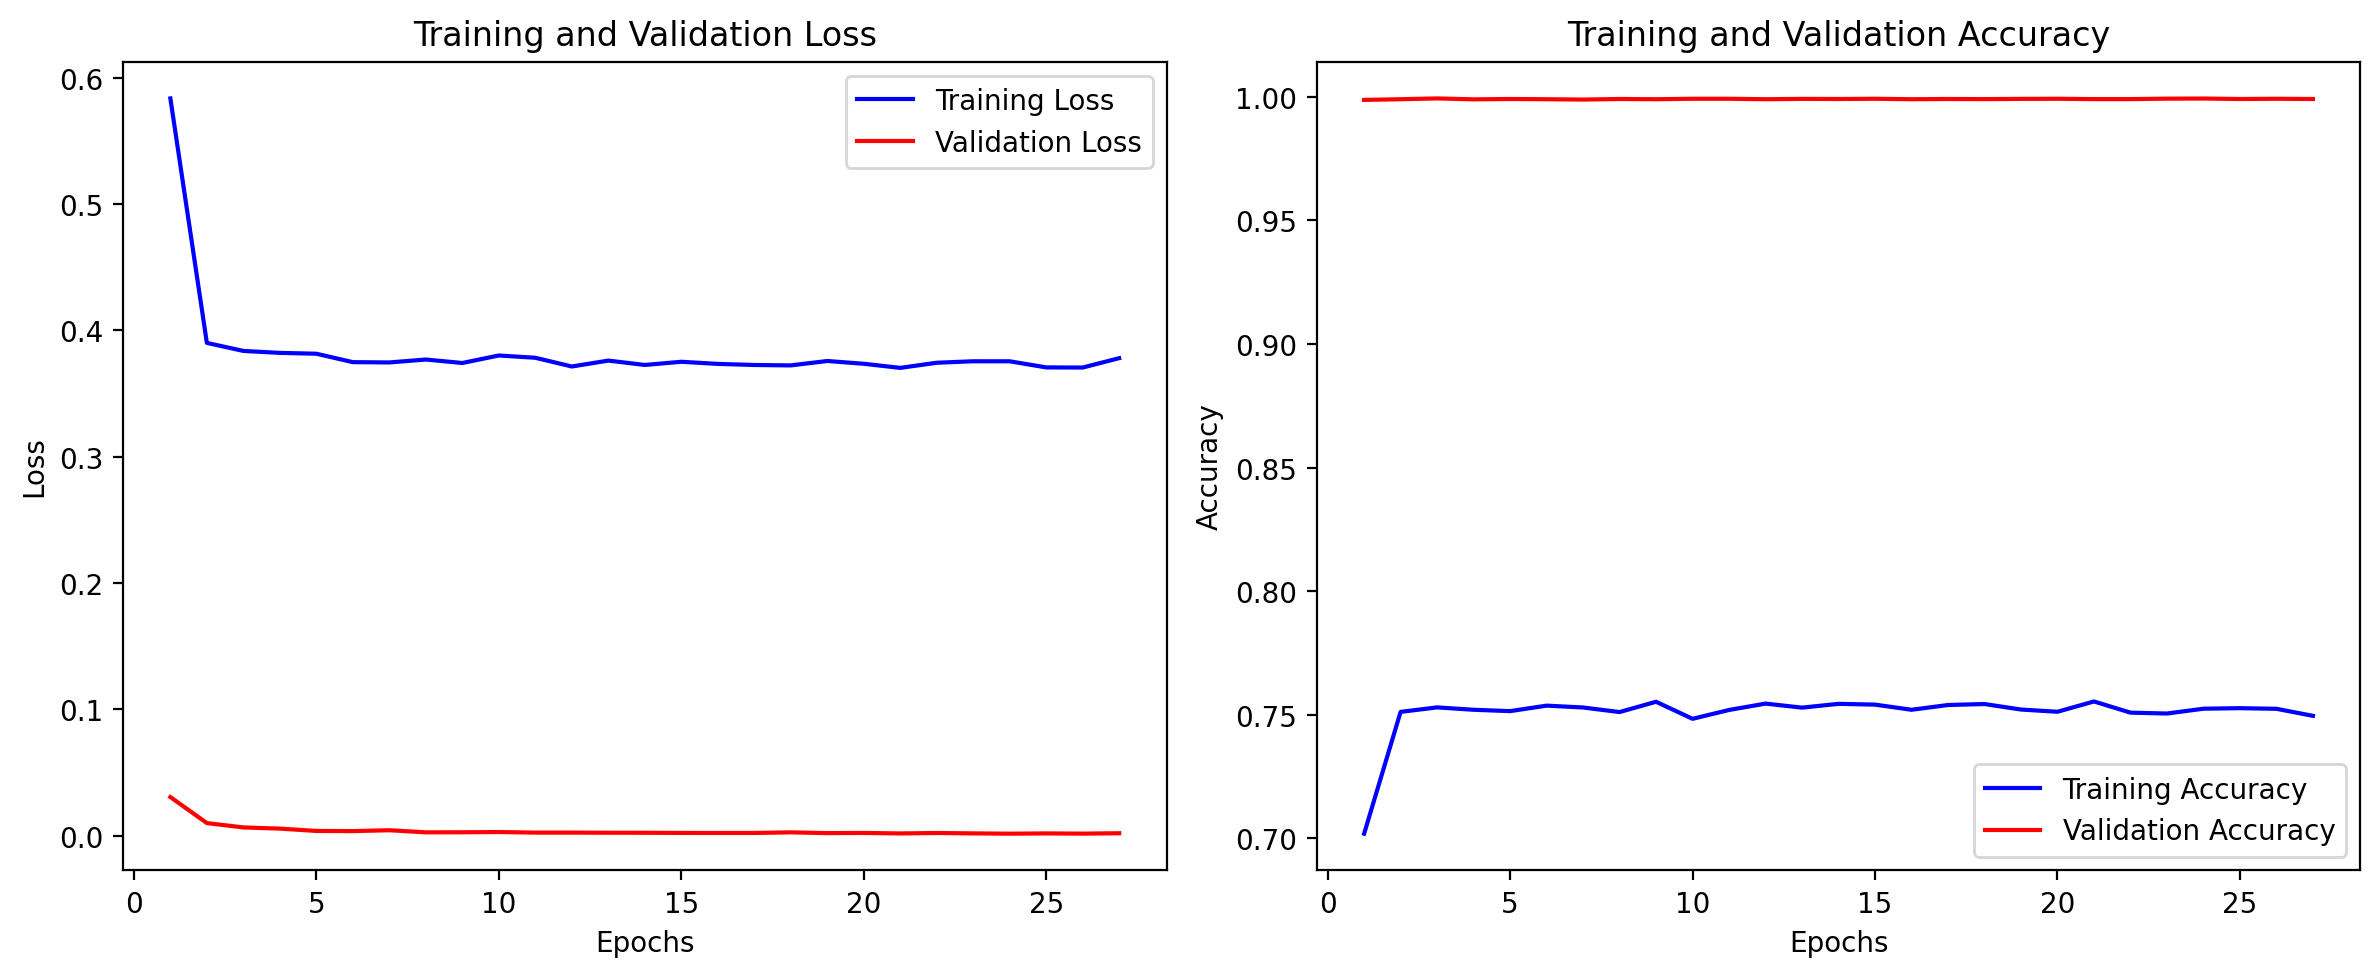

In [23]:
# Plotting the losses
plt.figure(figsize=(12, 5))

# Plot Training and Validation Losses
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(valid_losses)+1), valid_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, len(valid_accuracies)+1), valid_accuracies, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

F1 Score: 0.9992


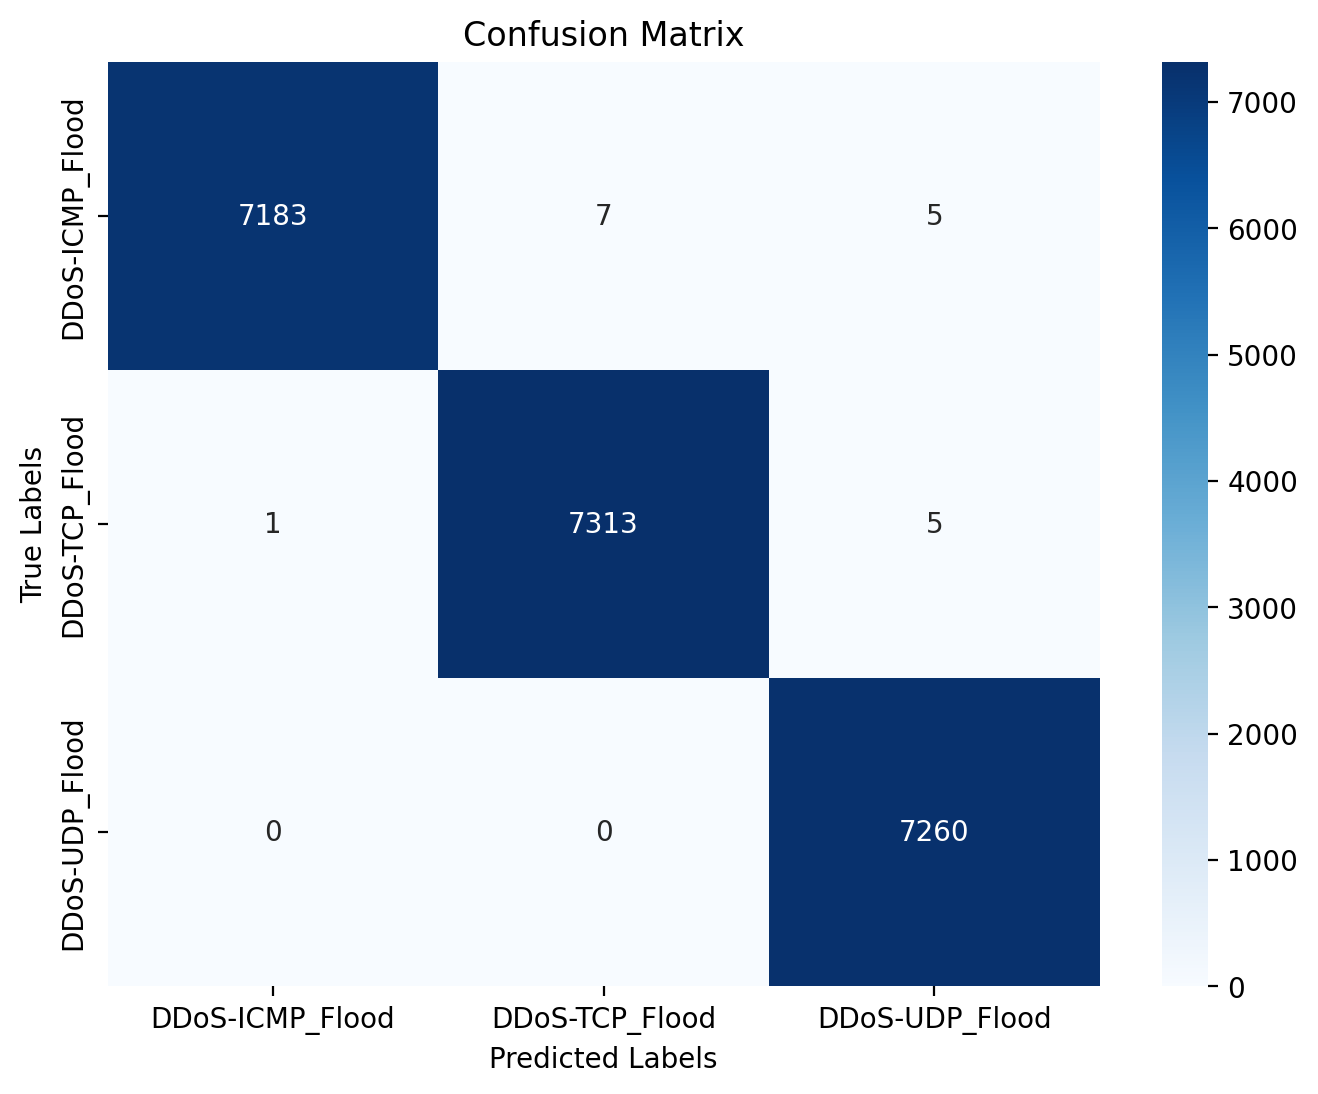

In [24]:
def generate_predictions(model, validloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in validloader:
            log_ps = model(inputs)
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            all_preds.extend(top_class.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Get predictions and true labels
all_preds, all_labels = generate_predictions(my_model, public_loader_labeled)

# Calculate F1 score
f1 = f1_score(all_labels, all_preds, average='macro')

# Print F1 score
print(f"F1 Score: {f1:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix with class names
class_labels = label_encoder.classes_
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()